In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from argparse import Namespace
from logging import warning
import os.path as osp
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

/data/engs-oxnsg/lady6515/.conda/envs/exphormer/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CONFIGURATION

# manual

dataset = 'Cifar10'
num_display_graphs = 1000


# automatic

layer_dirs = [dir for dir in glob(f'plot_data/outdegrees/{dataset}/*') if osp.isdir(dir) and dir.split('/')[-1][:5] == 'layer']
num_layers = len(layer_dirs)


In [8]:
oc_ys

tensor([0.0000e+00, 7.6536e+00, 9.8437e+00, 1.1508e+01, 1.2632e+01, 1.3490e+01,
        1.4784e+01, 1.4721e+01, 1.5272e+01, 1.6614e+01, 1.7100e+01, 1.6962e+01,
        1.7556e+01, 1.8239e+01, 1.8970e+01, 1.9080e+01, 1.9680e+01, 2.0502e+01,
        2.1438e+01, 2.1280e+01, 2.2260e+01, 2.3016e+01, 2.1670e+01, 2.2816e+01,
        2.4432e+01, 2.4525e+01, 2.4024e+01, 2.3544e+01, 2.5788e+01, 2.4563e+01,
        2.5200e+01, 2.6319e+01, 2.4608e+01, 2.5278e+01, 2.5568e+01, 2.6950e+01,
        2.7432e+01, 2.5678e+01, 2.6980e+01, 2.5194e+01, 2.7040e+01, 2.5830e+01,
        3.1122e+01, 2.7219e+01, 2.7984e+01, 3.0465e+01, 3.0084e+01, 2.7025e+01,
        2.9136e+01, 3.0037e+01, 3.0200e+01, 2.9580e+01, 2.8340e+01, 3.0157e+01,
        3.0024e+01, 3.1295e+01, 3.0632e+01, 2.9754e+01, 3.0798e+01, 3.3689e+01,
        2.8920e+01, 3.0988e+01, 3.2922e+01, 3.3390e+01, 3.4432e+01, 3.5100e+01,
        3.2208e+01, 3.3165e+01, 3.5632e+01, 3.4569e+01, 3.4090e+01, 3.4861e+01,
        3.6216e+01, 3.3142e+01, 3.3966e+

layer 0, seed 0: left, right
layer 0, seed 1: left, right
layer 0, seed 2: left, right
layer 0, seed 3: left, right
layer 0, seed 4: left, right
layer 1, seed 0: left, right
layer 1, seed 1: left, right
layer 1, seed 2: left, right
layer 1, seed 3: left, right
layer 1, seed 4: left, right
layer 2, seed 0: left, right
layer 2, seed 1: left, right
layer 2, seed 2: left, right
layer 2, seed 3: left, right
layer 2, seed 4: left, right
layer 3, seed 0: left, right
layer 3, seed 1: left, right
layer 3, seed 2: left, right
layer 3, seed 3: left, right
layer 3, seed 4: left, right
layer 4, seed 0: left, right
layer 4, seed 1: left, right
layer 4, seed 2: left, right
layer 4, seed 3: left, right
layer 4, seed 4: left, right


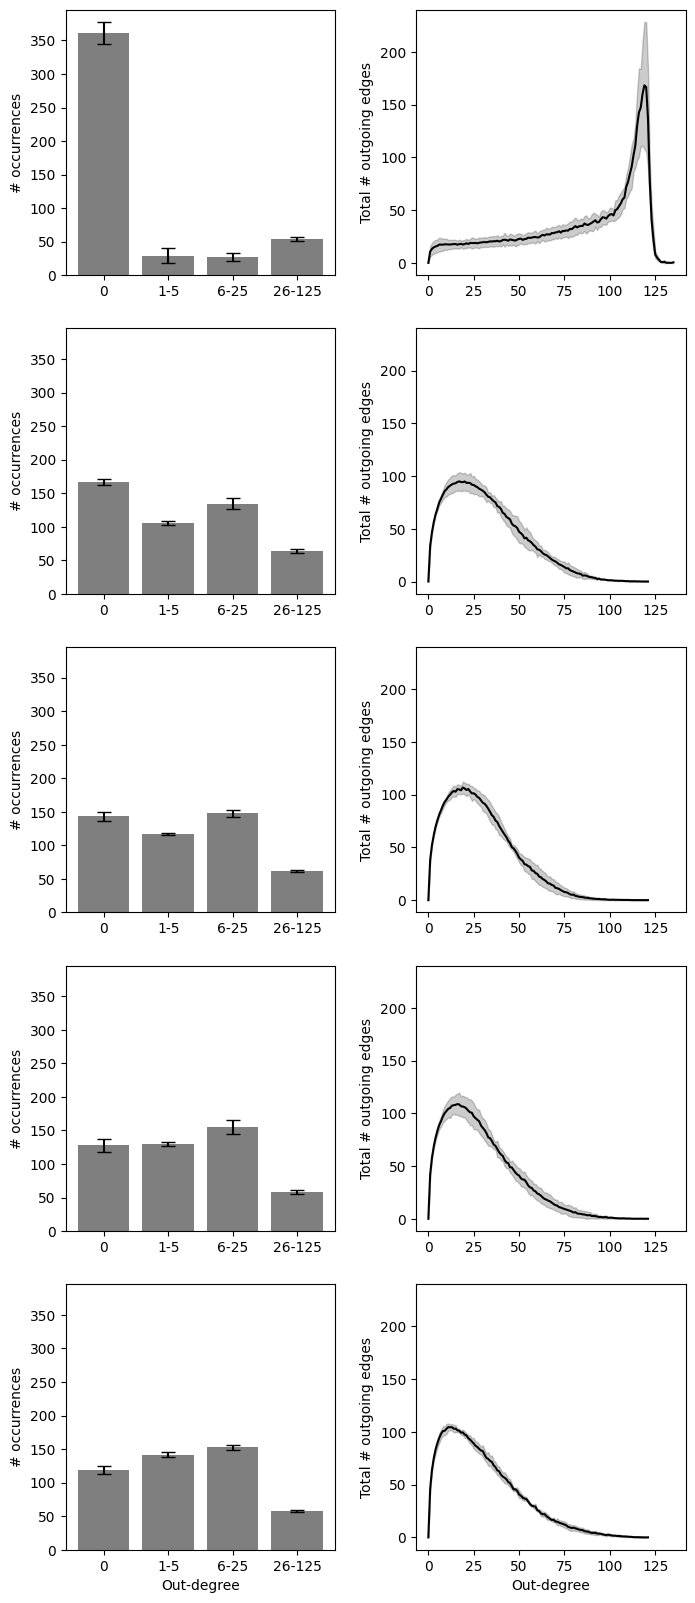

In [27]:
def mean(l):
    return sum(l) / len(l)

# prepare figure for plotting out degree statistics
fig_od, axs_od = plt.subplots(5, 2, figsize=(8,20), sharey='col', sharex='col')
plt.subplots_adjust(hspace=0.2, wspace=0.3)
axs_od[-1,0].set_xlabel("Out-degree")
axs_od[-1,1].set_xlabel("Out-degree")
for row in range(5):
    # axs[row,0].set_xlabel("Out-degree")
    axs_od[row,0].set_ylabel("# occurrences")
    axs_od[row,0].xaxis.set_tick_params(labelbottom=True)

    # axs[row,1].set_xlabel("Out-degree")
    axs_od[row,1].set_ylabel("Total # outgoing edges")
    axs_od[row,1].xaxis.set_tick_params(labelbottom=True)

for layer_num in range(num_layers):
# for layer_num in range(1):
    bar0s = []
    bar1_5s = []
    bar6_25s = []
    bar26_125s = []
    bar126_s = []
    occurrences_counts_ys = []

    for seed in range(5):
        print(f"layer {layer_num}, seed {seed}: ", end="")

        occurrences_counts = torch.load(f'plot_data/outdegrees/{dataset}/layer{layer_num}/{seed}.pt')

        bar0 = (occurrences_counts==0).count_nonzero() / num_display_graphs
        bar1_5 = torch.logical_and(1 <= occurrences_counts, occurrences_counts <= 5).count_nonzero() / num_display_graphs
        bar6_25 = torch.logical_and(6 <= occurrences_counts, occurrences_counts <= 25).count_nonzero() / num_display_graphs
        bar26_125 = torch.logical_and(26 <= occurrences_counts, occurrences_counts <= 125).count_nonzero() / num_display_graphs
        bar126_ = (126 <= occurrences_counts).count_nonzero() / num_display_graphs

        bar0s.append(bar0)
        bar1_5s.append(bar1_5)
        bar6_25s.append(bar6_25)
        bar26_125s.append(bar26_125)
        bar126_s.append(bar126_)

        occurrences_counts_ys.append(torch.bincount(occurrences_counts, weights=occurrences_counts / num_display_graphs))

        # Plotting the histogram
        # bars = ['0', '1-5', '6-25', '26-125', '126-625']
        # heights = [bar0, bar1_5, bar6_25, bar26_125, bar126_]

        # axs_od[layer_num,0].bar(bars, heights, alpha=0.3)

        print("left", end="")

        # axs_od[layer_num,1].hist(occurrences_counts, bins=torch.arange(0, max(occurrences_counts)+1, 2), weights=occurrences_counts / num_display_graphs, alpha=0.3)
        # axs_od[layer_num,0].set_title(f"Layer {layer_num}", rotation=90, x=-0.3, y=0.48, va='center', ha='right')

        print(", right")

    # plotting the mean and std of each bar
    bars = ['0', '1-5', '6-25', '26-125']
    means = [np.mean(bar) for bar in (bar0s, bar1_5s, bar6_25s, bar26_125s)]
    stds = [np.std(bar) for bar in (bar0s, bar1_5s, bar6_25s, bar26_125s)]

    axs_od[layer_num,0].bar(bars, means, yerr=stds, capsize=5, color='black', alpha=0.5)


    # pad occurrence_counts_ys with zeros
    max_len = max([len(oc) for oc in occurrences_counts_ys])
    occurrences_counts_ys = [torch.cat([oc, torch.zeros(max_len-len(oc))]) for oc in occurrences_counts_ys]

    # Plotting the mean and std of the out-degrees
    occurrences_counts_ys = torch.stack(occurrences_counts_ys)
    mean = occurrences_counts_ys.mean(dim=0)
    std = occurrences_counts_ys.std(dim=0)
    axs_od[layer_num,1].plot(mean, label='mean', color='black')
    axs_od[layer_num,1].fill_between(torch.arange(len(mean)), mean-std, mean+std, alpha=0.2, label='std', color='black')